# Slopes for Simulated Videos

#### Using cross correlation pixel results directly to find slopes, elasticity, and speed.

In [2]:
#import functions

import numpy as np
from numpy import linalg

import cv2 as cv
import scipy
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import shutil

from skimage.morphology import skeletonize
import skimage.io
from sklearn.mixture import GaussianMixture as GMM
from sklearn.linear_model import LinearRegression
from sklearn import mixture
from sklearn.cluster import DBSCAN

from functions import *
from wave_detection.line_detection_gmm import *

In [4]:
#cross correlation function

def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y


In [ ]:
# #ONLY RUN ONCE
# #making folders
# os.mkdir('sim_2perc')
# os.mkdir('sim_2perc_crop')

In [89]:
# #ONLY RUN ONCE
# #extracting frames from the simulated 2 percent G1100 video
# video_name = 'test2percent_G1100_cut'
# path_to_source = 'data/' + video_name + '.avi'
# cap = cv.VideoCapture(path_to_source)
# num_frames = 50
# l=0
# m=0
# while l <= num_frames:
#     ret, frame = cap.read()
#     if not ret: 
#         print('No frames grabbed!')
#         break
#     cv.imwrite(f'sim_2perc/{m}.jpg', frame)
#     l+=1
#     m+=1

In [ ]:
# #ONLY RUN ONCE
# # crop images for faster calculation 
# data_path = 'sim_2perc/'
# data_save = 'sim_2perc_crop/'
# x_start = 50
# x_end = 100
# y_start = 5
# y_end = 55
# crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

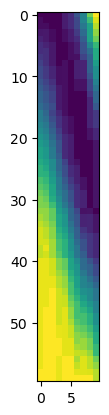

In [5]:
# example: cross correlation for one pixel
frNum = 10
path_to_images = 'sim_2perc_crop/'
kernel = 1
threshold_bin = 0
pixel = [50, 50]
_, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)

plt.imshow(corr_full_y)

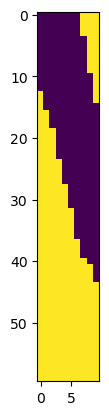

In [6]:
#example: clean version
T=80
image = np.copy(corr_full_y)
image[corr_full_y<T] = 0
image[corr_full_y>=T] = 1
plt.imshow(image)


Text(16, 60, 'y = 3.79 + 2.59x')

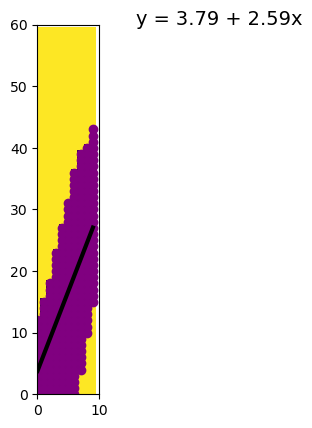

In [8]:
#example: fitting a line to cross correlation clean version from above (flipped)

plt.imshow(image)

#finding where the value is zero in the image matrix and filling that region with scatter points
zero_coords = np.argwhere(image==0)
plt.xlim(0,10)
plt.ylim(0,60)
plt.scatter(zero_coords[:,1],zero_coords[:,0], color='purple')

#find line of best fit for scatter
slope, b = np.polyfit(zero_coords[:,1], zero_coords[:,0], 1)

#add line of best fit to plot
plt.plot(zero_coords[:,1], slope*zero_coords[:,1]+b, color='black', linestyle='-', linewidth=3)

#add fitted regression equation to plot
plt.text(16, 60, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(slope) + 'x', size=14)

In [9]:
#for each pixel in whichever image, run cross correlation function to get to clean version and use scatter points to fit line

frNum = 10
path_to_images = 'sim_2perc_crop/'
kernel = 1
threshold_bin = 0

image_cross = cv.imread(path_to_images + '12.jpg', cv.IMREAD_GRAYSCALE)
slopes = np.zeros([image_cross.shape[0], image_cross.shape[1]])  # empty matrix of 50x50

for i in range(image_cross.shape[0]):
    for j in range(image_cross.shape[1]):
        pixel=[i, j]
        try:
            _, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)
        
            T=80
            image = np.copy(corr_full_y)
            image[corr_full_y<T] = 0
            image[corr_full_y>=T] = 1
            #finding where the value is zero in the image matrix and filling that region with scatter points
            zero_coords = np.argwhere(image==0)
            #find line of best fit for scatter
            slope, b = np.polyfit(zero_coords[:,1], zero_coords[:,0], 1)
        except ValueError:
            slope=None
        slopes[i, j] = slope
        #print(slopes)


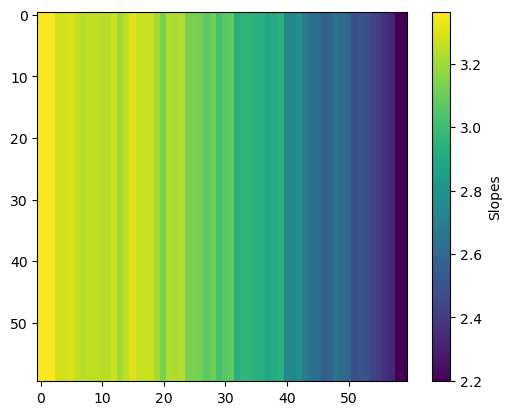

In [10]:
#plotting slopes from above for in each pixel, colorbar used as legend
plt.imshow(slopes)
plt.colorbar(label='Slopes')

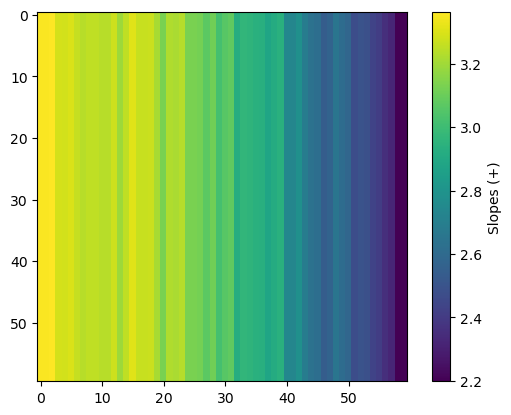

In [17]:
#making negative slopes positive, doesn't actually affect plot
new_slopes = slopes
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        if new_slopes[i,j]<0:
            new_slopes[i,j] *= -1
plt.imshow(new_slopes)
plt.colorbar(label='Slopes (+)')

In [12]:
# calculate elasticity
def elasticity_HT (slopes, dens, conv_pix, conv_fr):
    conv_factor = (conv_pix * conv_fr)
    mu = ((slopes * conv_factor)**2) * dens
    return mu

In [13]:
# Compute elasticity
dens = 1000
conv_pix = (1/2)*1e-6
conv_fr = 300000

mu = elasticity_HT(slopes, dens, conv_pix, conv_fr)

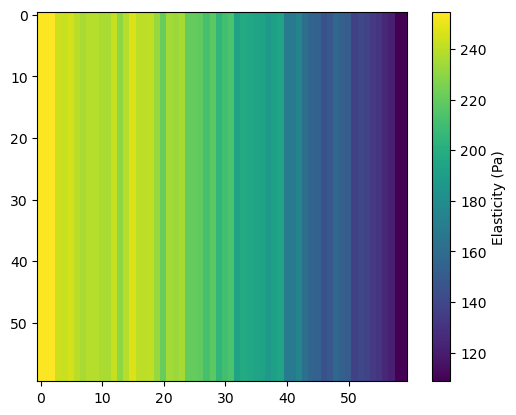

In [14]:
#plot elasticity
plt.imshow(mu)
plt.colorbar(label='Elasticity (Pa)')


In [15]:
#finding speed
speed = np.sqrt(mu/dens)
np.median(speed)

0.45982961817260326

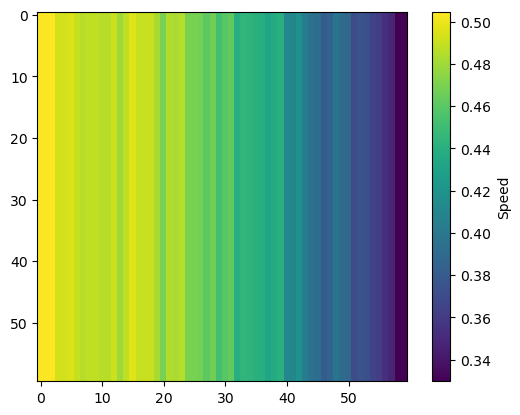

In [16]:
plt.imshow(speed)
plt.colorbar(label='Speed')